In [1]:
import os
import dill as pickle
import matplotlib
matplotlib.use('Agg')
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from utils.utils import load_group_results, Result_obj
from stable_baselines.results_plotter import ts2xy
from stable_baselines.bench.monitor import load_results
from utils import extract_param_val

from utils import plot
import re
from tqdm import tqdm
%matplotlib inline

# set up matplotlib

plt.ion()
# plt.rc('font', family='serif', serif='Times')

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        'axes.titlesize' : 14,
        "axes.labelsize": 14,
        "font.size": 10,
        'font.weight':'bold',
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 6,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        'font.weight':'bold',
        'axes.labelweight': 'bold'
}

# nice_fonts = {
#         # Use LaTeX to write all text
#         "text.usetex": True,
#         "font.family": "serif",
#         # Use 10pt font in plots, to match 10pt font in document
#         'axes.titlesize' : 16,
#         "axes.labelsize": 17,
#         "font.size": 15,
#     'lines.linewidth': 2,
#         # Make the legend/label fonts a little smaller
#         "legend.fontsize": 13,
#         "xtick.labelsize": 16,
#         "ytick.labelsize": 16,
# }

matplotlib.rcParams.update(nice_fonts)


/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# group plot for comparing MLAP vs training from scratch

In [2]:
env_algo_xlim_ybase_legend = [
    ('RoboschoolHopper-v1', 'ppo2', int(2e6), 500, False),
    ('CartPole-v1','ppo2', int(1e5), 100, True), 
    ('RoboschoolInvertedPendulumSwingup-v1', 'ppo2', int(2e6), 200, False), 
    ('RoboschoolAnt-v1', 'ppo2', int(2e6), 500, False),  
    ('Acrobot-v1', 'ppo2', int(2e5), 50, False), 
    ('LunarLanderContinuous-v2', 'sac', int(5e5), 100, False)]

prefixes = ["4sources-3sets-SIW", "1sources-3sets-SIW"]


override=False
save=True
fig_width_inches = 5.5 / 1.0
font_scale = 1.5
color_dict = {'MLP': 'blue', 'MULTIPOLAR(K=1)': 'green', 'MULTIPOLAR(K=4)': 'red'}

###############
# Golden ratio to set aesthetic figure height
golden_ratio = (5**.5 - 1) / 2

# Figure height in inches
fig_height_inches = fig_width_inches * golden_ratio
figsize = (fig_width_inches, fig_height_inches)

In [ ]:
for env, algo, xlim, ybase, legend in env_algo_xlim_ybase_legend:
    save_path = "logs/{}_analysis/plots".format(env)
    os.makedirs(save_path, exist_ok=True)
    
    for exp in os.listdir('logs/{}_scratch'.format(algo)):

        if env in exp and exp[-1]=='1':
            
            # remove the experiment numbder
            exp = exp[:-2] 
            file = os.path.join(save_path, '{}.pkl'.format(exp))
            
            # if file exists, do not load
            if override or not os.path.isfile(file):

                # load results of training from scratch
                results = load_group_results('logs/{}_scratch'.format(algo), env=env, verbose=True, mask="^logs/{}_scratch/{}_*".format(algo, exp))
                # remove env name from the experiment name
                exp = ''.join(exp.split('_')[1:])
                for p in prefixes:
                    try:
                        results += load_group_results('logs/mlap-{}/'.format(algo), env='{}_{}'.format(env, p), verbose=True, mask="^((?!no-bias).)*{}_[1-9]$".format(exp))
                    except:
                        pass
                with open(file, 'wb') as f:
                        pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
                    
            else:
                with open(file, 'rb') as f:
                    results = pickle.load(f)

            # create title
            title = env[:-3]
    #         title = env + '\n'
    #         param_val extract_param_val(exp.split('-'))
    #         for param, val in param_val:
    #             title += '{}:{} '.format(param, val)
    # #             digit = param[ind:]
    # #             param = param[:ind]
    # #             zero_ind = digit.find('0') + 1
    # #             if zero_ind == 0:
    # #                 zero_ind = -2
    # #             title += '{}:{}.{} '.format(param, digit[:zero_ind], digit[zero_ind:])


            # only keep algo name for visualization
            refined_results=[]
            for i in range(len(results)):

                if pd.isnull(results[i][0].r).any() or pd.isnull(results[i][0].t).any():
                    continue

                r = {'monitor': results[i][0].astype({"r":'float64', "l":'float64', "t":'float64'})}

                path = results[i][1].split('/')
                config = path[-1]
                name = path[-2]
                if 'mlap' in name:
                    name="MULTIPOLAR"
                    ind = config.rfind('sources')
                    name += '(K={})'.format(config[ind-1])
                else:
                    name="MLP"

                r['dirname'] = 'logs/{}/{}_{}'.format(name, env, results[i][1].split('_')[-1])
                refined_results.append(Result_obj(**r))

            f, _ = plot.plot_results(refined_results, average_group=True, shaded_std=False, legend_outside=False, xaxis='timesteps', smooth_step=3, title=title, 
                                     font_scale=font_scale, figsize=figsize, color_dict=color_dict, xbase=xlim/4, ybase=ybase, legend=legend)
            try:
                if xlim > 0:
                    plt.xlim([0, xlim])
            except:
                pass
                
            if save:
                f.savefig(os.path.join(save_path, '{}.pdf'.format(exp)), bbox_inches='tight', format='pdf', dpi=300)
                print('>>>> saved {}'.format(exp))
            else:
                plt.show()

successfully loaded logs/ppo2_scratch/RoboschoolHopper-v1_leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_1
successfully loaded logs/ppo2_scratch/RoboschoolHopper-v1_leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_2
successfully loaded logs/ppo2_scratch/RoboschoolHopper-v1_leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_3
loaded 3 results
successfully loaded logs/mlap-ppo2/RoboschoolHopper-v1_4sources-3sets-SIW-leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_1
successfully loaded logs/mlap-ppo2/RoboschoolHopper-v1_4sources-3sets-SIW-leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_2
successfully loaded logs/mlap-ppo2/RoboschoolHopper-v1_4sources-3sets-SIW-leg051-foot043-thigh047-torso04-size086-damping276-friction115-armature183_3
exception loading monitor file in logs/mlap-ppo2/RoboschoolHopper-v1_4sources-3sets-SIW-leg051-foot043-thigh047-torso04-size0

# average MLP vs. Multipolar

In [ ]:
for env, algo, xlim, ybase, legend in env_algo_xlim_ybase_legend:
    save_path = "logs/{}_analysis/plots".format(env)
    file = os.path.join(save_path, 'all.pkl')
    if override or not os.path.isfile(file):
        # load results of training from scratch
        results = load_group_results('logs/{}_scratch'.format(algo), env=env, verbose=True)

        for p in prefixes:
            try:
                # results += load_group_results('logs/mlap-{}/'.format(algo), env=env, verbose=True, mask="^logs/mlap-{}/{}_{}-{}_*".format(algo, env, p, exp))
                results += load_group_results('logs/mlap-{}/'.format(algo), env='{}_{}'.format(env, p), verbose=True, mask='^((?!no-bias).)*$')
            except:
                pass
            with open(file, 'wb') as f:
                pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
    else:
        with open(file, 'rb') as f:
            results = pickle.load(f)
        
    # create title
    title = env[:-3]
    refined_results=[]
    # only keep algo name for visualization
    for i in tqdm(range(len(results))):

        if pd.isnull(results[i][0].r).any() or pd.isnull(results[i][0].l).any():
            continue
            
        r = {'monitor': results[i][0].astype({"r":'float64', "l":'float64', "t":'float64'})}

        path = results[i][1].split('/')
        config = path[-1]
        name = path[-2]

        
        if 'mlap' in name:
            name="MULTIPOLAR"
            ind = config.rfind('sources')
            name += '(K={})'.format(config[ind-1])
        else:
            name="MLP"

        r['dirname'] = 'logs/{}/{}_{}'.format(name, env, results[i][1].split('_')[-1])
        
        refined_results.append(Result_obj(**r))

    f, _ = plot.plot_results(refined_results, average_group=True, shaded_std=True, shaded_err=False, legend_outside=False, xaxis='timesteps', title=title, 
                             font_scale=font_scale, figsize=figsize, color_dict=color_dict, xbase=xlim/4, ybase=ybase, legend=legend)
    try:
        if xlim > 0:
            plt.xlim([0, xlim])
    except:
        pass
    
    if save:
        save_path = "logs/{}_analysis/plots".format(env)
        os.makedirs(save_path, exist_ok=True)
        f.savefig(os.path.join(save_path, 'all.pdf'), bbox_inches='tight', format='pdf', dpi=300)
    else:
        plt.show()
    plt.show()

In [11]:
len(results)

2076

# load results from the given path with regular expression

In [44]:
results = load_group_results('logs/ppo2/', verbose=True, mask="^logs/ppo2/.*max-speed2.*")
results += load_group_results('logs/ppo2/', verbose=True, mask="^logs/ppo2/.*orig.*")

successfully loaded logs/ppo2/MountainCar-v0_max-speed2_1
loaded 1 results
successfully loaded logs/ppo2/MountainCar-v0_orig_1
loaded 1 results


(<Figure size 1263.6x595.44 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff94bf1048>]],
       dtype=object))

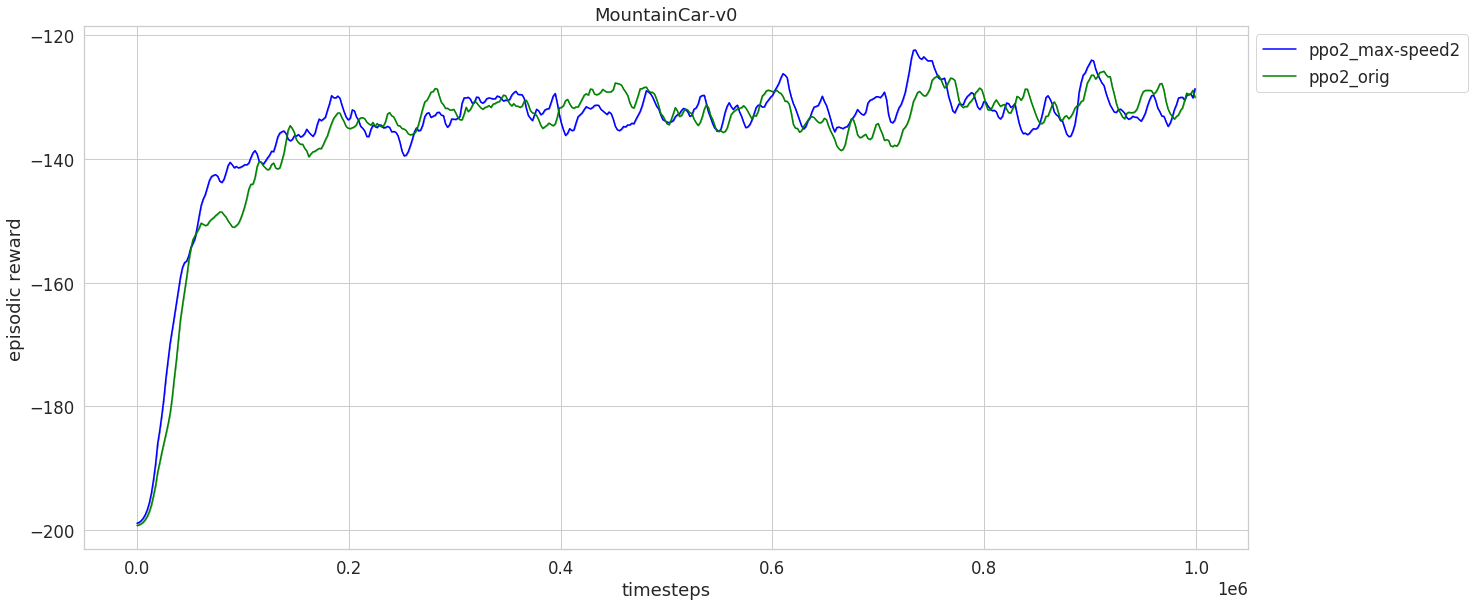

In [45]:
plot.plot_results(results, average_group=True, shaded_std=False, ybase=20, legend_outside=True, xaxis='timesteps', smooth_step=3, style='whitegrid')

#### evaluate the success rate

In [3]:
thresh = 200

In [7]:
avg_last_hundred_ep = []
for r in results:
    x, y = ts2xy(r.monitor, 'episodes')
    avg_last_hundred_ep.append(np.mean(y[-100:]))
avg_last_hundred_ep = np.array(sorted(avg_last_hundred_ep))

In [8]:
sum(avg_last_hundred_ep >= thresh) / 300

0.97